### Setup / packages / crs

In [122]:
import geopandas as gp
from shapely import wkt
import pandas as pd
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly

In [69]:
pd.set_option('display.max_columns', None)

In [2]:
worldmap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
usa = gp.read_file("data/cb_2018_us_nation_5m.shp")
us_states = gp.read_file("data/cb_2018_us_state_500k.shp")
ca_state = gp.read_file("/Users/natebender/Desktop/repo/capstone_rmi/data/CA_State_TIGER2016.shp")
ca_counties = gp.read_file("/Users/natebender/Desktop/repo/capstone_rmi/data/CA_Counties_TIGER2016.shp")

In [53]:
# set common crs for project
projcrs = 4326
us_states = us_states.to_crs(projcrs)  # match us_states common crs for project
worldmap = worldmap.to_crs(projcrs)
ca_state = ca_state.to_crs(projcrs)
ca_counties = ca_counties.to_crs(projcrs)

In [130]:
# read in Refineries

cols = list(pd.read_csv("data/asset-climate-trace_oil-refining_091922.csv", nrows =1))
refs = pd.read_csv("data/asset-climate-trace_oil-refining_091922.csv", 
                   usecols = lambda x: x not in ['other1', 'other2', 'other3', 
                                                 'other4', 'other5', 'other6', 'other7'])
refs['location'] = gp.GeoSeries.from_wkt(refs['location'])  # convert existing points to geoseries
refs = gp.GeoDataFrame(refs, geometry="location", crs=projcrs,)  # convert df to geodf

#### next step: write function to read in all excel files and assign each to ind geodfs

In [131]:
# Read excel file

# type of production: flaring, supply chain: upstream, year: 2021
flare_up_21 = pd.read_excel("/Users/natebender/Desktop/repo/capstone_rmi/data/VIIRS_Global_flaring_d.7_slope_0.029353_2021_web (2).xlsx",
             sheet_name="flare upstream")

# Convert lat/long to points in geodataframe and set crs to common project crs
flare_up_21 = gp.GeoDataFrame(
    flare_up_21, geometry=gp.points_from_xy(flare_up_21["Longitude"], 
                                            flare_up_21["Latitude"]), 
    crs = projcrs)



/Users/natebender/opt/anaconda3/envs/capstonermi37/lib/python3.7/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


### Functions

In [16]:
def display_table(table_name, attribute_table):
    '''Display the first and last two rows of attribute table.'''

    # Print title
    print("Attribute Table: {}".format(table_name))

    # Print number of rows and columns
    print("\nTable shape (rows, columns): {}".format(attribute_table.shape))

    # Display first two rows of attribute table
    print("\nFirst two rows:")
    display(attribute_table.head(2))

    # Display last two rows of attribute table
    print("\nLast two rows:")
    display(attribute_table.tail(2))


def plot_overlay(overlay_type, overlay_result):
    '''Plot the overlay result on a map and add the outlines of the original shapefiles on top.'''

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))

    # Plot overlay data
    overlay_result.plot(ax = ax, cmap = 'Set2', edgecolor = 'black')

    # Plot outlines of original shapefiles
    ca_counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
    #watersheds.plot(ax = ax, color = 'none', edgecolor = 'dodgerblue')

    # Stylize plots
    plt.style.use('bmh')

    # Set title
    ax.set_title('San Francisco Bay Area County and Watershed Boundaries\n{}'.format(overlay_type), fontdict = {'fontsize': '15', 'fontweight' : '3'})


In [38]:
print(worldmap.crs)
print(flare_up_21.crs)

epsg:4326
epsg:4326


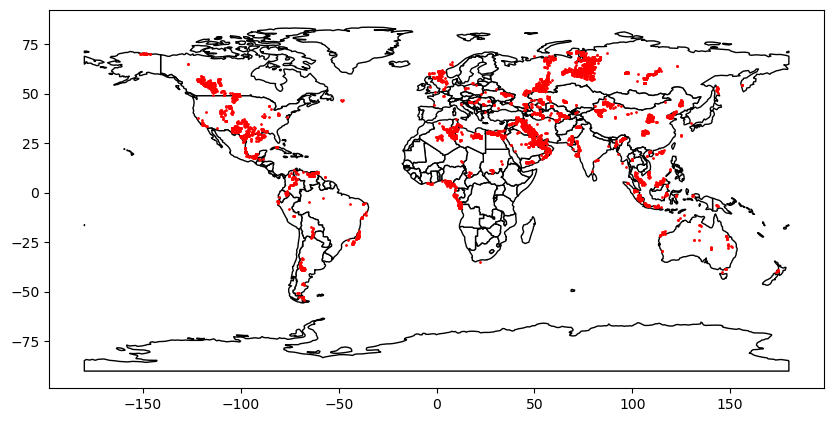

In [39]:
# Keeping worldmap in the orig crs of 4326 plots the points correctly, even though it and the flares dataframe
# are in different crs???

fig, ax = plt.subplots(figsize = (10,8))
worldmap.plot(ax = ax, color = 'white', edgecolor = 'black')
flare_up_21.plot(ax = ax, color='red', markersize=1)  # increase size for visibility
plt.show()

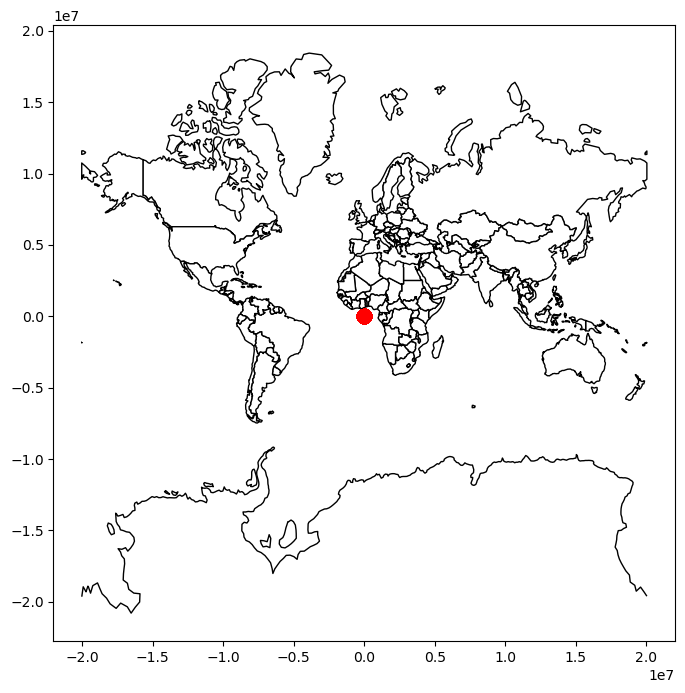

In [42]:
# putting the worldmap in the 3857 crs completely destroys the plotting. Don't know why yet.
# Perhaps it's something to do with the units, all the flares are plotted at 0,0 here.  
worldmap_new = worldmap.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize = (10,8))
worldmap_new.plot(ax = ax, color = 'white', edgecolor = 'black')
flare_up_21.plot(ax = ax, color='red', markersize=100)  # increase size for visibility
plt.show()

### Section 1

In [78]:
# subset to just lower 48 plus AK
# remove territories: PR, PW, VI, MH, GU
# and AK, HI
stateslist = ["AL","AR","AZ","CA","CO","CT","DC","DE","FL","GA","IA","ID", "IL","IN","KS","KY","LA","MA","MD","ME","MI","MN","MO","MS","MT","NC","ND","NE","NH","NJ","NM","NV","NY", "OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VA","VT","WA","WI","WV","WY"]
us_states = us_states[us_states['STUSPS'].isin(stateslist)]
#us_states.sort_values(by=['NAME'], ascending=True)

In [55]:
#syntax: df.loc[df['col1'] == value]
#flare_up_21 = flare_up_21.loc[flare_up_21["ISO Code"] == "USA"]  # subset to just USA

# drop orig lat/long cols. They're unnecessary now w geodataframe
#flare_up_21.drop(['Latitude', 'Longitude'], axis=1, inplace=True)  

#us_flares = flare_up_21.loc[flare_up_21["ISO Code"] == "USA"]  # subset to just USA



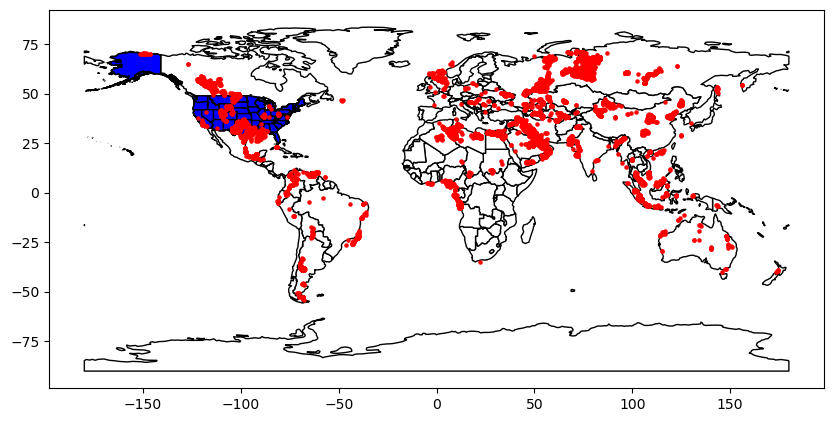

In [56]:
# # Plotting multiple layers
fig, ax = plt.subplots(figsize = (10,8))
worldmap.plot(ax = ax, color = 'white', edgecolor = 'black')
us_states.plot(ax = ax, color = 'blue', edgecolor = 'black')
flare_up_21.plot(ax = ax, color = 'red', markersize = 5)
plt.show()

In [136]:
# only works if crs match

# match dfs with just CA counties
inner_join_result = gp.sjoin(flare_up_21, ca_counties, how = "inner", op = 'within')
refs_join = gp.sjoin(refs, ca_counties, how='inner', op='within')

In [135]:
# match ds with US states

inner_join_result = gp.sjoin(flare_up_21, us_states, how = "inner", op = 'within')
refs_join = gp.sjoin(refs, us_states, how='inner', op='within')

In [98]:
len(inner_join_result)

2990

### Testing plots

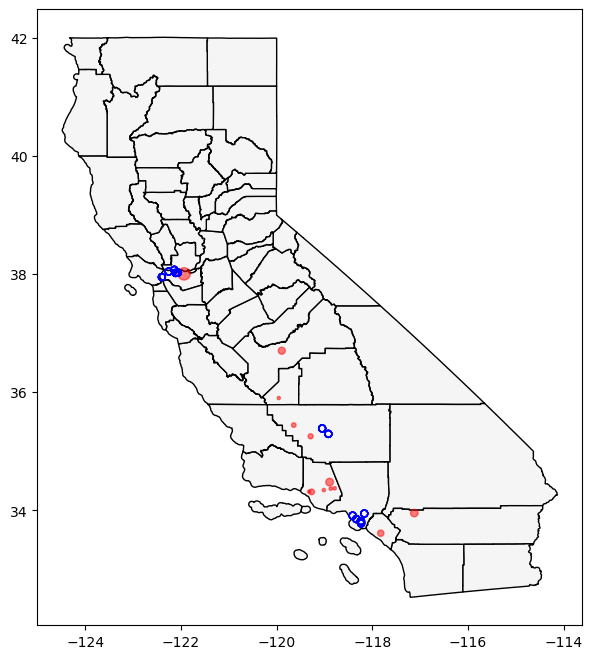

In [143]:
# # Plotting multiple layers
fig, ax = plt.subplots(figsize = (10,8))
#worldmap.plot(ax = ax, color = 'white', edgecolor = 'black')
#us_states.plot(ax = ax, color = 'whitesmoke', edgecolor = 'black')
ca_counties.plot(ax = ax, color = 'whitesmoke', edgecolor = 'black')
inner_join_result.plot(ax = ax, color = 'red', alpha=.5, markersize=inner_join_result['BCM 2021']*10000)
refs_join.plot(ax=ax, facecolors='none', color='blue', markersize=25)
#plt.ylim([33, 39])  # can zoom for readability
plt.show()